In [155]:
import numpy as np
import utils
import plotting_tools as pt

from importlib import reload
import utils
utils = reload(utils)
pt = reload(pt)

from scipy import signal

In [156]:
Ny = 1
Nx, Nz = 256, 256
# Nx, Nz = 128, 128
# Nx, Nz = 64, 64
et = 86400.0*10.0
# et /= 1200.0
N = 1

def load(Nx,Ny,Nz,et):
    base_fn = 'output_swe'
    pydir = '../%s/' %base_fn

    tc = utils.test_case(base_fn, pydir, Nx, Ny, et, Nz=Nz)
    tags = tc.get_tag_dict()
    
    return tc, tags
tc, tags = load(Nx,Ny,Nz,et)

after_full_step
120000.0


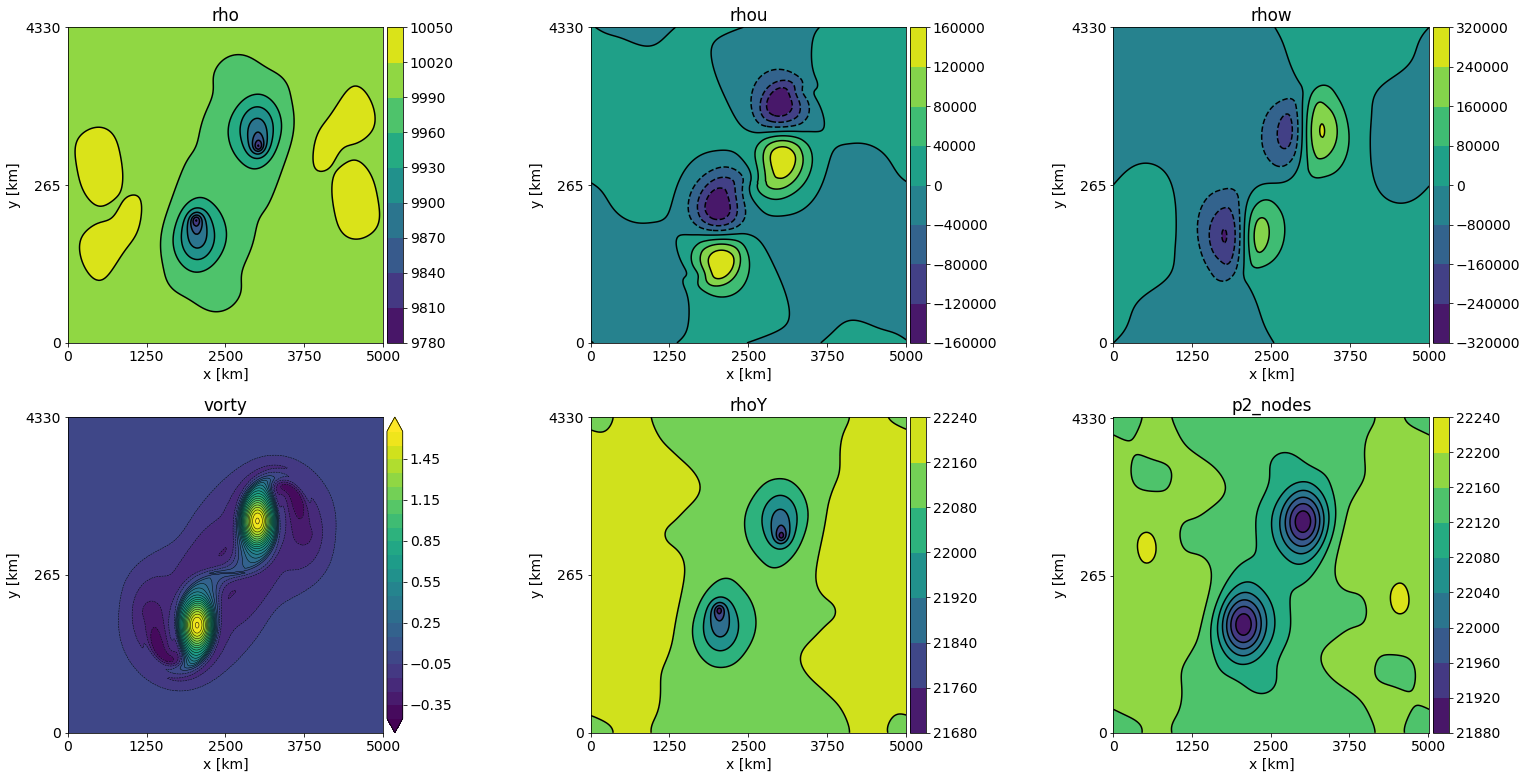

In [181]:
# comp_sfx = 'comp_last_working_ic0'
# H = 'optimal'
# comp_sfx = 'comp_H=%s' %str(H)
comp_sfx = 'icshear_3D'
comp_sfx = 'icshear_comp'
# comp_sfx = 'dvortex_3D_last_working'
# comp_sfx = 'dvortex_comp'
comp_sfx = 'icshear_12s'
comp_sfx = 'dvortex_12s'
fn = tc.get_filename(N,comp_sfx)
path = tc.get_path(fn)

attributes = ['rho','rhou','rhow','vorty','rhoY','p2_nodes']
# attributes = tc.get_debug_attrs()
# attributes = ['rho','rhou','rhov','rhow','rhoX','rhoX','rhoY','p2_nodes']
# attributes = ['vorty']
# attributes = ['rho','rhoY','Y']
# attributes = ['rho']

times = np.array([3.0,6.0,10.0])*86400.0
times = np.array([3.0]) * 86400.0
# times = np.array([72.0])*6
# times *= 1200.0
# times = np.array([10.0]) * 86400.0 
# times = np.arange(0,et,1200)

# times = [86400]
# times = [72*10-1]
# times = [2,5,9]
times = [120000.0]

lbls = [3.0,6.0,10.0]
# lbls = [10.0]
# t_lbl = [1.0]
# t_lbl = times
# t_lbl = 'WINDOW_STEP'

# t_lbl = [10.0]

tag = tags[9]
print(tag)
# tag = 'ic'
H = 1076.0

slc = 0
arr_lst = []
time_series = np.zeros((np.array(times).shape[0],len(attributes),2), dtype='object')

class oo(object):
    def __init__(self):
        None
        
oo = oo()
t_lbl = 'TIME'
# times = [0]
# t_lbl = 'WINDOW_STEP'


for tt,time in enumerate(times):
    print(time)
#     arr_lst = []
    for atr_idx, attribute in enumerate(attributes):
        arr = tc.get_arr(path, time, N, attribute, label_type=t_lbl, tag=tag, inner=True, avg=False)[0][:,slc,:]
        arr = arr.T
        
        if attribute == 'rho':
            rho = np.copy(arr)

        if attribute == 'vorty':
            kernel = np.array([[1.0,1.0],[1.0,1.0]])
            kernel /= kernel.sum()
            arr = signal.convolve(arr, kernel, mode='valid')
            arr /= rho
            arr *= 86400.0*1000#/1200
#             arr = arr[::-1,:]


#         if tt == 0:
        setattr(oo,attribute,arr)
    
#         if attribute == 'p2_nodes':
#             diff = arr.max() - arr.min()
#             print(diff)
#             arr -= arr.min()
#             diff_aft = arr.max() - arr.min()
#             print(diff_aft)
            
#             arr *= diff

#         if tt == 2:
#             arr -= getattr(oo,attribute)
            
        arr_lst.append([arr,attribute])
#         arr_lst.append([arr,"%s at t=%.1f days" %('pot. vorticity',lbls[tt])])
        
        arr = [arr,attribute]
        time_series[tt,atr_idx] = arr

fs = (22,5.5)
fs = (22,12)
# fs = (6,6)
ncolslen = int(len(attributes)/2) if len(attributes) > 1 else 1
pl = pt.plotter(arr_lst,ncols=ncolslen,figsize=fs,sharey=False)
lvl = np.arange(-0.45,1.7,0.1)
# lvl = np.arange(-8.0,10.0,1.0)
lvls = [None] * len(attributes)
lvls[3] = lvl
# lvls = lvl
# lvls = np.arange(-11.0,11.1,2)

# lvls = np.arange(1000,1200,10)
# lvls = np.arange(H-60,H+42,2)
x_axs = [0,1250,2500,3750,5000]
y_axs = [0,265,4330]
x_loc = np.linspace(0,Nx-1,5)
y_loc = np.linspace(0,Nz-1,3)
x_label = r'x [km]'
y_label = r'y [km]'
st = 'SWE shear flow (%ix%i), $\Delta t = 12s$. Potential vorticity in the (x-z) plane.' %(Nx,Nz)
st = '(%ix%i)' %(Nx,Nz)

pl.set_axes(x_locs=x_loc, y_locs=y_loc, x_axs=x_axs, y_axs=y_axs, x_label=x_label, y_label=y_label)
# _ = pl.plot(aspect='equal',method='contour',suptitle=st,lvls=lvls)
_ = pl.plot(aspect='equal',method='contour',lvls=lvls)
# _ = pl.plot(aspect='equal',method='contour',suptitle=st)
#     ts.append(arr_lst)
# pl.save_fig('icshear')

In [5]:
p2ncp = oo.p2_nodes

In [106]:
p2oo = p2ncp.max() - p2ncp.min()
print(p2oo)

p2f = p2oo * (p2ncp - p2ncp.min())


2095.023


737.7902
-1.2051424


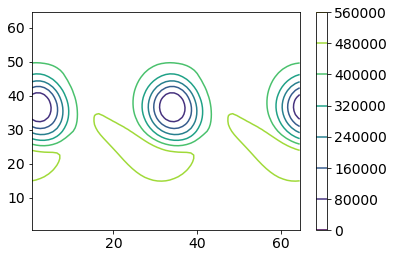

In [8]:
p2n = oo.p2_nodes
p2nn = p2n.max() - p2n.min()
print(p2nn)
print(p2n.mean())

import matplotlib.pyplot as plt
plt.figure()
plt.contour(p2nn*(p2n - p2n.min()), origin='lower')
plt.colorbar()
plt.show()

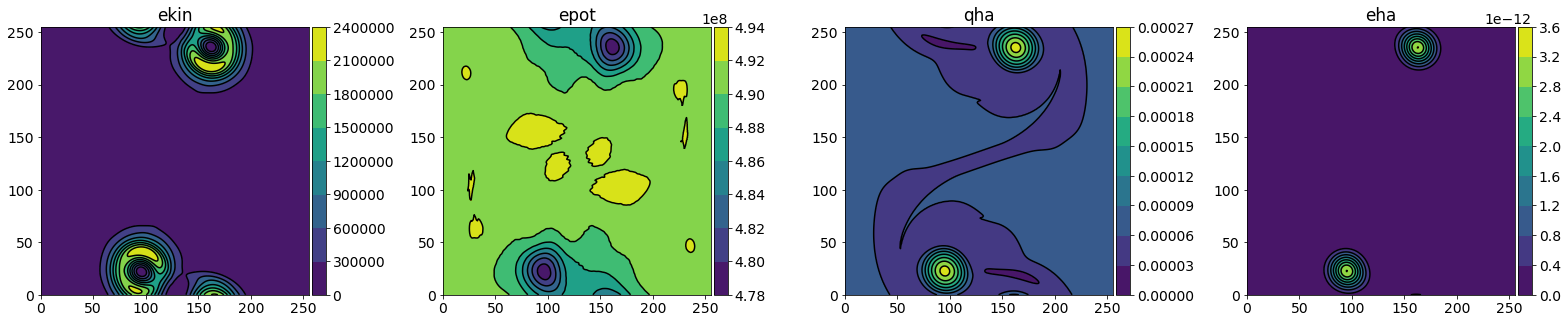

In [9]:
from scipy import integrate, signal

Nx, Nz = 128, 128
Nx, Nz = 256, 256
# Nx, Nz = 64, 64
Ny = 1
N = 1
et = 86400.0*10.0

tc, tags = load(Nx,Ny,Nz,et)

comp_sfx = 'icshear_3D'
# comp_sfx = 'dvortex_3D_12s_nw'
comp_sfx = 'dvortex_3D'

fn = tc.get_filename(N,comp_sfx)
path = tc.get_path(fn)
times = np.arange(0,719)
times = np.arange(0,et,1200)[1:]

href = 1.0
tref = 1.0
uref = href / tref

Lx, Lz = 5000.0*1E3 / href, 4330.0*1E3 / href
AA = Lx*Lz
LX = np.linspace(0,Lx,Nx+1)
LZ = np.linspace(0,Lz,Nz+1)

dx,dz = np.diff(LX)[0], np.diff(LZ)[0]
dxz = [dx,dz]

g0 = 9.81 / uref
f0 = 6.147 * 1E-5

i2 = (slice(2,-2),slice(2,-2))
i1 = (slice(1,-1),slice(1,-1))

def padder(f):
    return np.pad(f,(0,1),mode='wrap')

def iint(f,dxy):
    dim = 2
    f = padder(f)
    for d in range(dim):
#         print(dim)
        dd = dxy[d]
        f = integrate.trapz(f,dx=dd,axis=0)
    return f

def getuv(oo):
    u, w = oo.rhou/oo.rho, oo.rhow/oo.rho
    u, w = u, w
#     return u/uref, w/uref
    return u, w

def energy(oo):
    u, v = getuv(oo)
    h = oo.rho / href
#     u, v, h = u[i2],v[i2],h[i2]
    
    ekin = 0.5 * (h) * (u**2 + v**2)
    ekin_arr = np.copy(ekin)
    ekin = iint(ekin,dxz)
    
    epot = 0.5 * g0 * h**2
    epot_arr = np.copy(epot)
    epot = iint(epot,dxz)

    return ekin + epot, ekin_arr, epot_arr

def pv(oo):
    hp = oo.rho #/ href
    vorty = oo.vorty
#     hp, vorty = hp[i2], vorty[i2]
    qh = hp * vorty
    qh_arr = np.copy(qh)
    qh = iint(qh, dxz)
    eh = hp * vorty**2
    eh_arr = 0.5*np.copy(eh)
    eh = iint(eh, dxz)
    return qh, 0.5*eh, qh_arr, eh_arr

def mass(oo):
    h = oo.rho
#     h = h[i2]
    m = iint(h,dxz)
    return m

es = []
pvs = []
pes = []
ms = []

class oo(object):
    def __init__(self):
        None
oo = oo()
slc = 0
H = 1076.0 / href

attributes = ['rho','rhou','rhow','vorty']

lt = 'TIME'
# lt = 'WINDOW_STEP'

for tt,time in enumerate(times):
    arrs = []
    for atr_idx, attribute in enumerate(attributes):
        arr = tc.get_arr(path, time, N, attribute, label_type=lt, tag=tag, inner=True, avg=False)[0][:,slc,:]
        arr = arr.T
        
        if attribute == 'rho':
            rho = np.copy(arr)
            setattr(oo,attribute,arr)
        
        if attribute == 'rhou' or attribute == 'rhow':
            setattr(oo,attribute,arr)
            
        if attribute == 'vorty':
            arr += f0
            kernel = np.array([[1.0,1.0],[1.0,1.0]])
            kernel /= kernel.sum()
            arr = signal.convolve(arr, kernel, mode='valid')
            arr /= rho
#             arr *= 86400.0*href
            setattr(oo,attribute,arr)
            
    ee, ekin, epot = energy(oo)
    es.append(ee)
    
    qh,eh, qha, eha = pv(oo)
    arrs.append([[ekin,'ekin'],[epot,'epot'],[qha,'qha'],[eha,'eha']])
    pvs.append(qh)
    pes.append(eh)
    ms.append(mass(oo))
    
    if tt == 700:
        pl = pt.plotter(arrs[0],ncols=4,figsize=(22,12))
        _ = pl.plot(aspect='equal',method='contour')

In [27]:
np.save('es%i' %Nx, es)
np.save('eh%i' %Nx, eh)

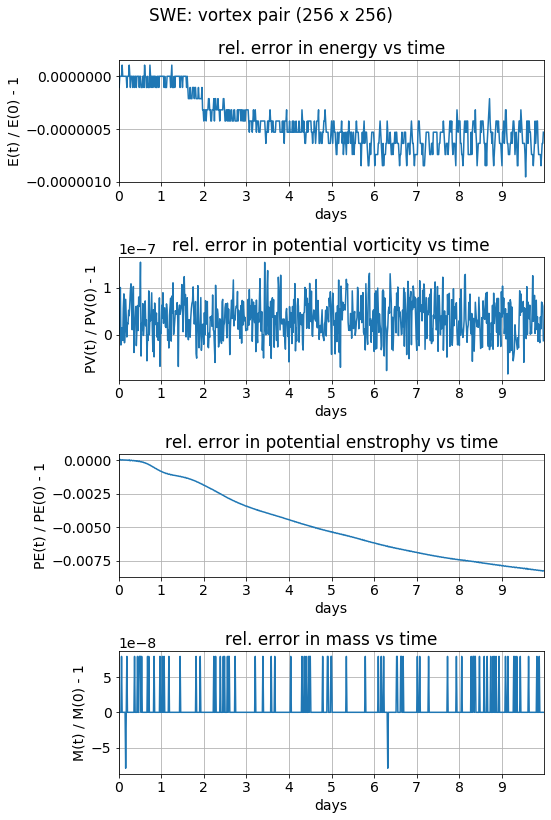

In [49]:
def get_rel_err(lst):
    lst = np.array(lst)
    lst[1:] -= lst[0]
    lst /= lst[0]
    lst[0] -= 1.0
    return lst

escp = get_rel_err(es)
pvscp = get_rel_err(pvs)
pescp = get_rel_err(pes)
mscp = get_rel_err(ms)

data = [escp,pvscp,pescp,mscp]
titles = ['energy', 'potential vorticity', 'potential enstrophy', 'mass']
titles = ['rel. error in %s vs time' %title for title in titles]
xlabel = 'days'
ylabels = ['E(t) / E(0) - 1', 'PV(t) / PV(0) - 1', 'PE(t) / PE(0) - 1', 'M(t) / M(0) - 1']

xtck = np.arange(0,721,72)
xtcklbl = np.arange(0,len(xtck))

import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=1,nrows=4,figsize=(8,12),sharex=False)
for ii in range(4):
    ax[ii].plot(data[ii])
    ax[ii].set_title(titles[ii])
    ax[ii].grid()
    ax[ii].set_xlabel(xlabel)
    ax[ii].set_ylabel(ylabels[ii])
    ax[ii].set_xticks(xtck)
    ax[ii].set_xticklabels(xtcklbl)
    ax[ii].set_xlim(0,len(escp))
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.suptitle('SWE: vortex pair (%i x %i)' %(Nx,Nz))
plt.show()

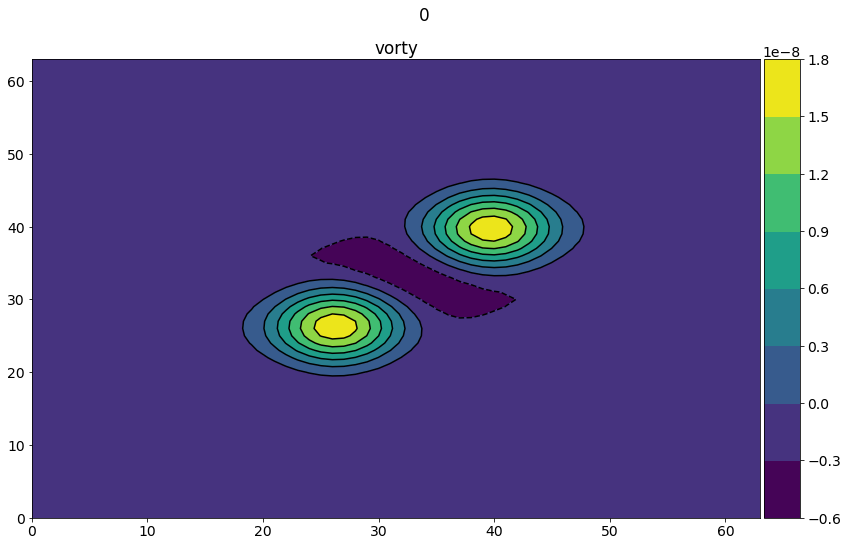

In [811]:
a2d = pt.animator_2D(time_series,ncols=3,figsize=(12,8))
anim = a2d.animate(interval=200, aspect='equal', method='contour')

In [812]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [295]:
Lx = 5000.0
Ly = 4330.0
sigx = 3.0 / 40 * Lx
sigy = 3.0 / 40 * Ly

sig = 0.5 * (sigx + sigy)
d = 4.0 * sig

In [63]:
# y = [-0.6915855407714844, -0.06304168701171875, -0.00130462646484375, 0.041015625, 0.15082550048828125, 3.5741424560546875]
# x = [50, 90, 93, 95, 100, 200]

y = [0.70944595, 0.06523895, 0.0018615723, -0.04156494, -0.1542511, -3.6651459]
x = [50, 90, 93, 95, 100, 200]

x = x[:-1]
y = y[:-1]
x = x[1:]
y = y[1:]

dx = x[-1] - x[0]
dy = y[-1] - y[0]

xx = np.arange(x[0],x[-1]+1)
b = y[2] - dy/dx * x[2]
# yy = dy/dx * xx + b

xo = -b / (dy/dx)
# print(xo)

z = np.polyfit(x, y, 1)
zz = np.poly1d(z)
root = np.roots(zz)
yy = z[0] * xx + z[1]

a = xo
# print(a)

plt.figure(figsize=(9,6))
plt.plot(x,y, '-o', label='measurements')
plt.xlabel("mean water height H")
plt.ylabel("deviation of the 'blob'")
plt.axvline(root, c='g', lw=1.0, label=r'optimal H $\approx$ %.3f' %root)
plt.plot(xx,yy, label='linear best fit')
plt.axhline(0.0, c='k', ls='--', lw=0.5)
plt.legend()
plt.grid()
plt.show()

print(root)

NameError: name 'plt' is not defined

In [140]:
%%capture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.animation as animation
import matplotlib
%matplotlib inline

from IPython.display import HTML

# ref: https://pythonmatplotlibtips.blogspot.com/2018/11/animation-3d-surface-plot-funcanimation-matplotlib.html
N = 150 # Meshsize
# et = 1E6

Lx, Lz = 1E6, 1E6
x = np.linspace(0,Lx,Nx) / 1000
z = np.linspace(0,Lz,Nz) / 1000

H = 100.0
N = 1

X, Z = np.meshgrid(x, z)

frns = np.arange(0,301) # animation frames
time_series = np.zeros((frns.shape[0],Nx,Nz))

comp_sfx = 'comp'
fn = tc.get_filename(N,comp_sfx)
path = tc.get_path(fn)

attribute = 'rho'

for ii,fr in enumerate(frns):
    time_series[ii] = tc.get_arr(path, fr, N, attribute, label_type='STEP', inner=True)[:,0,:] - H
    
def update_plot(frame_number, time_series, plot):
    plot[0].remove()
    plot[0] = ax.plot_surface(X, Z, time_series[frame_number,:,:], cmap="magma")

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

plot = [ax.plot_surface(X, Z, time_series[0,:,:], color='0.75', rstride=1, cstride=1)]
ax.set_zlim(-.5,.5)
ax.set_xlabel(r'$L_x$ [km]')
ax.set_ylabel(r'$L_z$ [km]')
ax.set_zlabel(r'$\delta h$ [m]')
ax.view_init(60, 45)
anim = animation.FuncAnimation(fig, update_plot, frns, fargs=(time_series, plot), interval=100)

In [141]:
HTML(anim.to_html5_video())

0.010000001


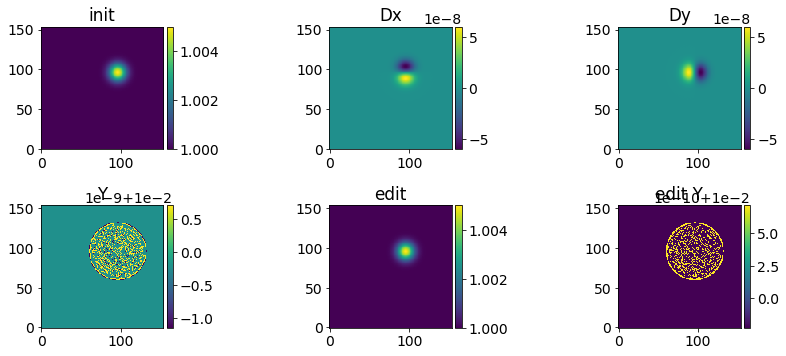

In [80]:
comp_sfx = 'comp'
fn = tc.get_filename(N,comp_sfx)
path = tc.get_path(fn)

init = tc.get_arr(path, 0, N, 'rhoY', label_type='STEP', tag='ic', inner=False, avg=False)[0]
init_rho = tc.get_arr(path, 0, N, 'rho', label_type='STEP', tag='ic', inner=False, avg=False)[0]

dx, dy = np.diff(x)[0], np.diff(y)[0]

Dx = np.gradient(init,dx,axis=0)
Dy = np.gradient(init,dy,axis=1)

# edit = init - (Dx + Dy)

# eDx = np.gradient(edit,dx,axis=0)
# eDy = np.gradient(edit,dy,axis=1)

edit = init_rho / 100.0
# edit -= edit.mean()
# edit += 1.0

arr_lst = [[init, "init"], [Dx,'Dx'], [Dy,'Dy']]
Y = init / init_rho
arr_lst += [[Y, 'Y'], [edit, 'edit'], [edit / init_rho, 'edit Y']]
# arr_lst += [[edit, "edit"], [eDx,'eDx'], [eDy,'eDy']]
pl = pt.plotter(arr_lst,ncols=3)
pl.plot(aspect='equal')


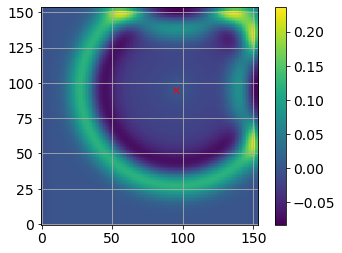

0.0010681152
0.9978649104014039


In [502]:
rhoY = tc.get_arr(path, 100, N, 'rho', label_type='STEP', inner=False, avg=False)[0]

idx = [103,93]
idx = [95,95]

rhoY = rhoY - H

plt.figure()
plt.imshow(rhoY[:,:], origin='lower',aspect='equal')
plt.plot(idx[0],idx[1],'rx')
plt.colorbar()
plt.grid()
plt.show()

print(rhoY[idx[0],idx[1]])
print((1.0 - rhoY[idx[0],idx[1]])**2)

In [504]:
0.16827393 /0.0010681152

157.54286616275098

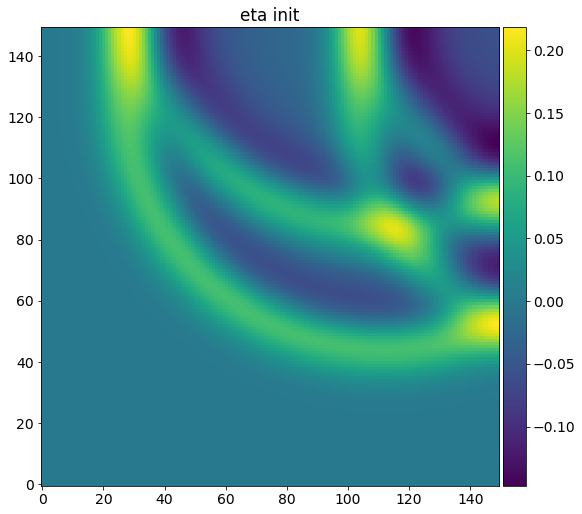

In [145]:
eta = np.load('../output_swe/eta_list.npy')

eta_init = eta[40]
eta_lst = [[eta_init, "eta init"]]
pl = pt.plotter(eta_lst,ncols=1)
pl.plot(aspect='equal')

In [15]:
loc = {
'rho' : 0,
'rhou' : 0,
'rhov' : 0,
'rhow' : 0,
'rhoY' : 0,
'rhoX' : 0,
'p2_nodes' : 2,
}
obs_attributes = ['rho','rhou','rhov','rhoY','p2_nodes']

for key,value in loc.items():
    print(key in obs_attributes)
    

True
True
True
False
True
False
True
